In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 3.6 MB/s eta 0:00:00


In [ ]:
!pip install pdfplumber

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 73.1 MB/s eta 0:00:00


In [ ]:
import os
import re
import pdfplumber
import pandas as pd
import numpy as np

In [ ]:
def extract_information(pdf_path):
    with pdfplumber.open(pdf_path) as pdf:
        resume_text = ""
        for page in pdf.pages:
            resume_text = " ".join([resume_text, page.extract_text()])
    resume_text = resume_text.strip()
    return resume_text

In [ ]:
def extract_details(resume_text):
    # Define regular expressions to extract Skills & Education
    skills_pattern = r'Skills\n([\s\S]*?)(?=\n[A-Z]|$)'
    education_pattern = r'Education\n([\s\S]*?)(?=\n[A-Z][a-z]*\n|$)'

    # Get Skills & Education
    skills_match = re.findall(skills_pattern, resume_text, re.DOTALL)
    education_match = re.findall(education_pattern, resume_text, re.DOTALL)

    # Skills & Education
    if len(skills_match)!=0:
        skills = skills_match[0]
    else:
        skills_pattern = r'skills\n((?:.*)*)'
        skills_match = re.findall(skills_pattern, resume_text, re.DOTALL)
        if len(skills_match)!=0:
            skills = skills_match[0]
        else:
            skills = None

    if len(education_match)!=0:
        education = education_match[0]
    else:
        education = None

    return {
        'Skills': skills,
        'Education': education
    }

In [7]:
data_folder = '/content/drive/MyDrive/dataset/Resume/data/data'
resume_data = []

# Iterate through sub-folders and PDF files
for category_folder in os.listdir(data_folder):
    category_path = os.path.join(data_folder, category_folder)
    if os.path.isdir(category_path):
        for pdf_file in os.listdir(category_path):
            if pdf_file.endswith('.pdf'):
                pdf_path = os.path.join(category_path, pdf_file)
                # print(pdf_path)
                text = extract_information(pdf_path)
                details = extract_details(text)

                # Adding Category & ID
                details['ID'] = pdf_file.replace('.pdf', '')
                details['Category'] = category_folder

                # print(f'File: [{pdf_path}]')
                # print(details, end='\n\n')
                resume_data.append(details)

print('PDF Extraction Done!')

PDF Extraction Done!


In [9]:
resume_df = pd.DataFrame(resume_data)
resume_df.to_csv('./pdf_extracted_skills_education.csv', index=False)

In [10]:
resume_df.shape

(2484, 4)

In [11]:
resume_df.isna().sum()

,0
Skills,91
Education,590
ID,0
Category,0


In [12]:
print(resume_df[(resume_df.Skills.isna() & resume_df.Education.isna())])

     Skills Education        ID                Category
76     None      None  29051656  INFORMATION-TECHNOLOGY
119    None      None  20237244  INFORMATION-TECHNOLOGY
170    None      None  16280971                   SALES
512    None      None  20566550             ENGINEERING
598    None      None  15499825              HEALTHCARE
1047   None      None  17576030                 FITNESS
1059   None      None  21178545                 FITNESS
1110   None      None  77266989                 FITNESS
1201   None      None  14849103            CONSTRUCTION
1814   None      None  90066849                DESIGNER
1862   None      None  14014749                DESIGNER
1929   None      None  14248724                    ARTS
1996   None      None  12632728    BUSINESS-DEVELOPMENT
2178   None      None  31225895                 APPAREL
2241   None      None  17021141                ADVOCATE


In [13]:
print(resume_df[~(resume_df['Skills'].isna() & resume_df['Education'].isna())].shape)

cv_df = resume_df[~(resume_df['Skills'].isna() & resume_df['Education'].isna())].reset_index(drop=True)
cv_df.head()

(2469, 4)


,Skills,Education,ID,Category
0,"Procurement Clerk, Purchasing Agent, Computer ...","Bachelor of Arts , Business Admin and Manageme...",51363762,INFORMATION-TECHNOLOGY
1,COMMUNICATION,None,21283365,INFORMATION-TECHNOLOGY
2,"Executive and Legal Support, Business Analysis...","2014 College of Lake County - City , State CFT...",91697974,INFORMATION-TECHNOLOGY
3,Project management Results-oriented,Family Financial Planning (Graduate Certificat...,16899268,INFORMATION-TECHNOLOGY
4,"Administrative, Analyst, Army, Agency, cable, ...",Bachelor of Science (BS) : Information Technol...,12045067,INFORMATION-TECHNOLOGY


In [14]:
cv_df.isna().sum()

,0
Skills,76
Education,575
ID,0
Category,0


In [15]:
cv_df[cv_df.Skills.isna()]

,Skills,Education,ID,Category
27,None,Bachelor of Science : Management Information S...,15118506,INFORMATION-TECHNOLOGY
37,None,"Master of Science , Computer Engineering Prese...",26746496,INFORMATION-TECHNOLOGY
43,None,M.B.A : Dec. 2007 University of Massachusetts ...,38753827,INFORMATION-TECHNOLOGY
44,None,"Bachelor's , Computer Information Systems DeVr...",28126340,INFORMATION-TECHNOLOGY
258,None,Bachelor of Arts : Journalism - Strategic Comm...,18525641,DIGITAL-MEDIA
...,...,...,...,...
2359,None,Bachelor of Arts : Economics City College of N...,82649935,ACCOUNTANT
2405,None,University of Phoenix Masters of Business Admi...,15363277,ACCOUNTANT
2431,None,"Ph.D : Soil, Water and Environmental Science 2...",24001783,AGRICULTURE
2456,None,"Master : Accounting (GPA 3.7) , 2009 McCombs S...",56068028,AGRICULTURE


In [16]:
cv_df[cv_df.Education.isna()]

,Skills,Education,ID,Category
1,COMMUNICATION,None,21283365,INFORMATION-TECHNOLOGY
6,"Programming and Scripting Languages: C++, Java...",None,20674668,INFORMATION-TECHNOLOGY
15,"ASP.Net 4.5, ASP.Net, VB.NET, Active Directory...",None,41344156,INFORMATION-TECHNOLOGY
16,"A+, A+ Certified, Active Directory, administra...",None,90867631,INFORMATION-TECHNOLOGY
18,Skills Experience Total Years Last Used,None,28897981,INFORMATION-TECHNOLOGY
...,...,...,...,...
2448,Time Management,None,28165687,AGRICULTURE
2461,"Customer service, art, clerical, doors, specia...",None,79536879,AGRICULTURE
2462,Strong interpersonal skills,None,38216888,AGRICULTURE
2464,"Adobe Creative Suite, Acrobat, After Effects, ...",None,89740812,AGRICULTURE


In [17]:
cv_df.Category.value_counts()

,count
Category,
BUSINESS-DEVELOPMENT,119
INFORMATION-TECHNOLOGY,118
FINANCE,118
ACCOUNTANT,118
CHEF,118
ENGINEERING,117
ADVOCATE,117
AVIATION,117
BANKING,115


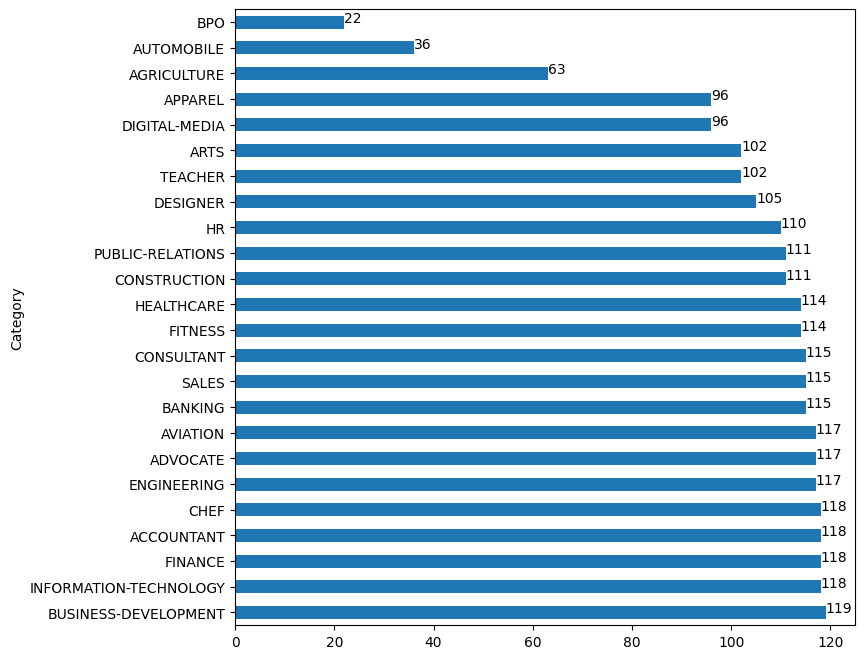

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))

cv_df.Category.value_counts().plot(kind='barh')

for index, value in enumerate(cv_df.Category.value_counts().values):
    plt.text(value, index, str(value))

plt.show();

In [19]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 8.2 MB/s eta 0:00:00


In [20]:
import numpy as np
import pandas as pd

import re
import string # for text cleaning
import contractions  # for expanding short form words
from tqdm import tqdm
tqdm.pandas(desc="Progress Bar")

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [21]:
df = pd.read_csv('/content/pdf_extracted_skills_education.csv')
df.head()

,Skills,Education,ID,Category
0,"Procurement Clerk, Purchasing Agent, Computer ...","Bachelor of Arts , Business Admin and Manageme...",51363762,INFORMATION-TECHNOLOGY
1,COMMUNICATION,NaN,21283365,INFORMATION-TECHNOLOGY
2,"Executive and Legal Support, Business Analysis...","2014 College of Lake County - City , State CFT...",91697974,INFORMATION-TECHNOLOGY
3,Project management Results-oriented,Family Financial Planning (Graduate Certificat...,16899268,INFORMATION-TECHNOLOGY
4,"Administrative, Analyst, Army, Agency, cable, ...",Bachelor of Science (BS) : Information Technol...,12045067,INFORMATION-TECHNOLOGY


In [22]:
df.shape

(2484, 4)

In [23]:
df.isna().sum()

,0
Skills,91
Education,590
ID,0
Category,0


In [24]:

print(df[(df.Skills.isna() & df.Education.isna())])

     Skills Education        ID                Category
76      NaN       NaN  29051656  INFORMATION-TECHNOLOGY
119     NaN       NaN  20237244  INFORMATION-TECHNOLOGY
170     NaN       NaN  16280971                   SALES
512     NaN       NaN  20566550             ENGINEERING
598     NaN       NaN  15499825              HEALTHCARE
1047    NaN       NaN  17576030                 FITNESS
1059    NaN       NaN  21178545                 FITNESS
1110    NaN       NaN  77266989                 FITNESS
1201    NaN       NaN  14849103            CONSTRUCTION
1814    NaN       NaN  90066849                DESIGNER
1862    NaN       NaN  14014749                DESIGNER
1929    NaN       NaN  14248724                    ARTS
1996    NaN       NaN  12632728    BUSINESS-DEVELOPMENT
2178    NaN       NaN  31225895                 APPAREL
2241    NaN       NaN  17021141                ADVOCATE


In [25]:
cv_df[cv_df.Education.isna()]

,Skills,Education,ID,Category
1,COMMUNICATION,None,21283365,INFORMATION-TECHNOLOGY
6,"Programming and Scripting Languages: C++, Java...",None,20674668,INFORMATION-TECHNOLOGY
15,"ASP.Net 4.5, ASP.Net, VB.NET, Active Directory...",None,41344156,INFORMATION-TECHNOLOGY
16,"A+, A+ Certified, Active Directory, administra...",None,90867631,INFORMATION-TECHNOLOGY
18,Skills Experience Total Years Last Used,None,28897981,INFORMATION-TECHNOLOGY
...,...,...,...,...
2448,Time Management,None,28165687,AGRICULTURE
2461,"Customer service, art, clerical, doors, specia...",None,79536879,AGRICULTURE
2462,Strong interpersonal skills,None,38216888,AGRICULTURE
2464,"Adobe Creative Suite, Acrobat, After Effects, ...",None,89740812,AGRICULTURE


In [26]:
cv_df.Category.value_counts()

,count
Category,
BUSINESS-DEVELOPMENT,119
INFORMATION-TECHNOLOGY,118
FINANCE,118
ACCOUNTANT,118
CHEF,118
ENGINEERING,117
ADVOCATE,117
AVIATION,117
BANKING,115


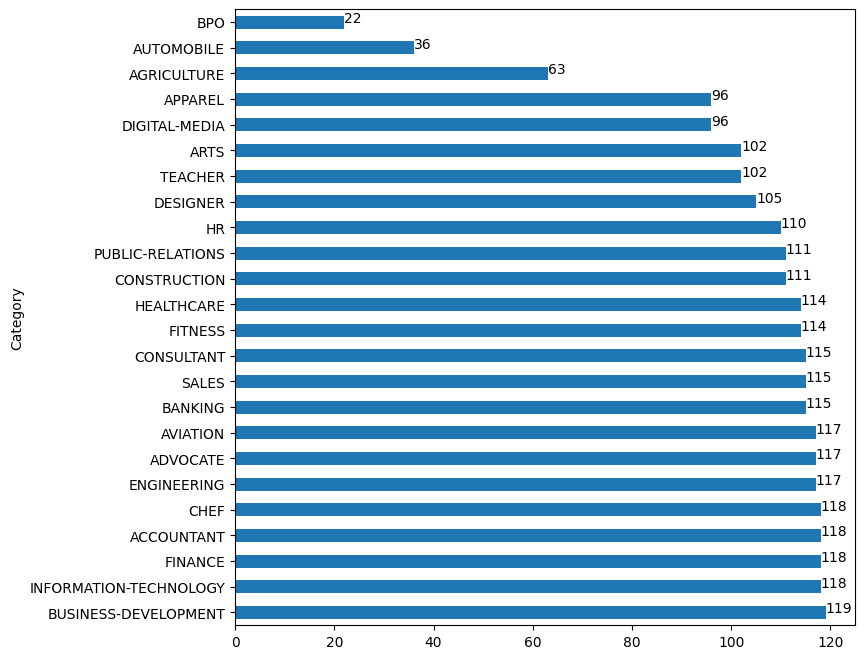

In [27]:
plt.figure(figsize=(8,8))

cv_df.Category.value_counts().plot(kind='barh')

for index, value in enumerate(cv_df.Category.value_counts().values):
    plt.text(value, index, str(value))

plt.show();

In [28]:
def text_cleaning(text:str) -> str:
    if pd.isnull(text):
        return

    # lower-case everything
    text = text.lower().strip()

    # For removing puctuations
    translator = str.maketrans('', '', string.punctuation)

    # expand all the short-form words
    text = contractions.fix(text)

    # remove any special chars
    text = re.sub(r'http\S+|www\S+|https\S+', '', text) # Remove URLs
    text = re.sub(r'\S+@\S+', '', text) # Remove emails
    text = re.sub(r'\b\d{1,3}[-./]?\d{1,3}[-./]?\d{1,4}\b', '', text) # Remove phone numbers
    text = text.translate(translator) # Remove puctuations
    text = re.sub(r'[^a-zA-Z]', ' ', text) # Remove other non-alphanumeric characters

    return text.strip()

In [29]:
resume_df = cv_df.copy()

# Filling the null values in Skills & Education with Empty String before concatinating them
resume_df = resume_df.fillna(value='')

resume_df['CV'] = resume_df['Skills'] + ' ' + resume_df['Education']
resume_df['CV'] = resume_df['CV'].progress_apply(text_cleaning)

Progress Bar: 100%|██████████| 2469/2469 [00:00<00:00, 5538.95it/s]


In [30]:
resume_df.head()

,Skills,Education,ID,Category,CV
0,"Procurement Clerk, Purchasing Agent, Computer ...","Bachelor of Arts , Business Admin and Manageme...",51363762,INFORMATION-TECHNOLOGY,procurement clerk purchasing agent computer pr...
1,COMMUNICATION,,21283365,INFORMATION-TECHNOLOGY,communication
2,"Executive and Legal Support, Business Analysis...","2014 College of Lake County - City , State CFT...",91697974,INFORMATION-TECHNOLOGY,executive and legal support business analysis ...
3,Project management Results-oriented,Family Financial Planning (Graduate Certificat...,16899268,INFORMATION-TECHNOLOGY,project management resultsoriented family fina...
4,"Administrative, Analyst, Army, Agency, cable, ...",Bachelor of Science (BS) : Information Technol...,12045067,INFORMATION-TECHNOLOGY,administrative analyst army agency cable cabli...


In [31]:
category_stats = []

for category in resume_df['Category'].unique():
    category_wise_cv = resume_df[resume_df['Category'] == category]['CV']
    stats = category_wise_cv.str.split().str.len().describe(percentiles=[0.05, 0.5, 0.8, 0.9, 0.95])
    category_stats.append({'Category': category, **stats.to_dict()})

stats_df = pd.DataFrame(category_stats)

# Display the resulting DataFrame
stats_df

,Category,count,mean,std,min,5%,50%,80%,90%,95%,max
0,INFORMATION-TECHNOLOGY,118.0,61.974576,70.105715,1.0,2.00,45.5,88.6,129.3,139.60,560.0
1,SALES,115.0,62.991304,125.206951,1.0,2.00,37.0,69.0,96.2,181.30,1062.0
2,DIGITAL-MEDIA,96.0,46.812500,43.288339,2.0,4.75,37.5,68.0,90.0,119.25,303.0
3,PUBLIC-RELATIONS,111.0,81.873874,115.654982,1.0,8.50,48.0,94.0,147.0,297.50,745.0
4,ENGINEERING,117.0,62.239316,91.660228,1.0,3.80,39.0,75.8,117.0,174.40,574.0
5,HEALTHCARE,114.0,85.298246,164.006471,1.0,3.00,39.5,80.8,113.7,498.45,905.0
6,TEACHER,102.0,71.156863,97.050742,2.0,6.00,42.0,81.8,158.1,224.20,586.0
7,HR,110.0,76.445455,138.636187,1.0,3.45,49.5,81.0,116.4,131.65,996.0
8,FINANCE,118.0,54.694915,46.293657,3.0,12.00,47.0,72.6,88.0,106.50,320.0
9,FITNESS,114.0,69.464912,112.362496,1.0,2.65,37.0,85.4,110.4,226.40,665.0


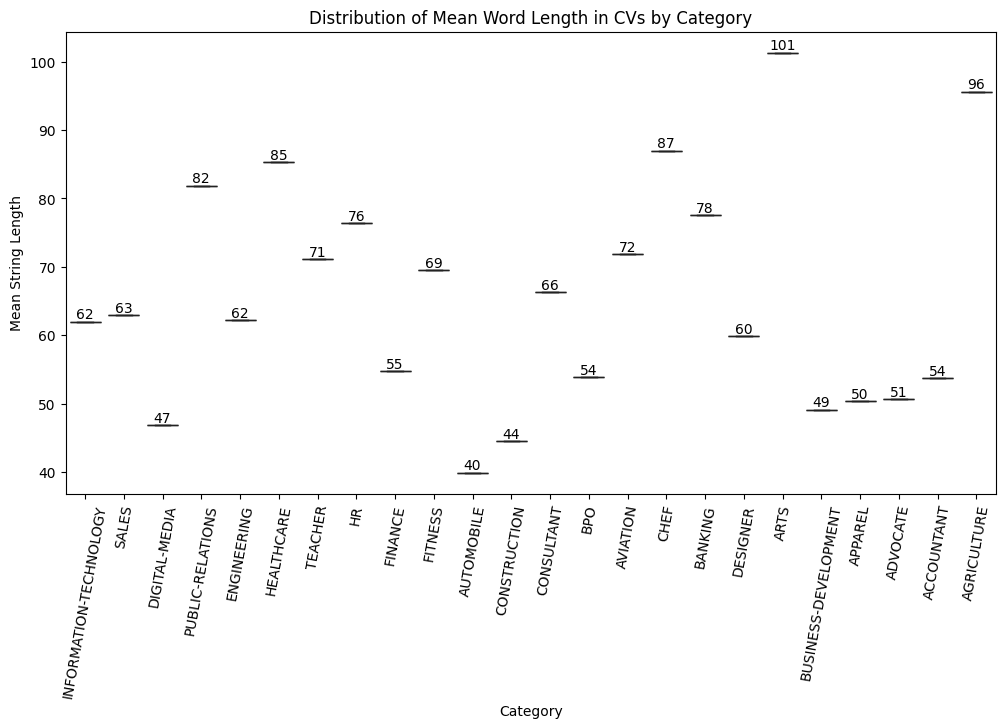

In [32]:
# Create a box plot to visualize the distribution of string lengths for each category
plt.figure(figsize=(12, 6))
sns.boxplot(data=stats_df, x='Category', y='mean', palette='viridis')

# Annotate the bars with actual values
for index, row in stats_df.iterrows():
    plt.text(index, row['mean'], f'{round(row["mean"])}', ha='center', va='bottom', fontsize=10)

plt.title('Distribution of Mean Word Length in CVs by Category')
plt.xticks(rotation=80)
plt.xlabel('Category')
plt.ylabel('Mean String Length')
plt.show();

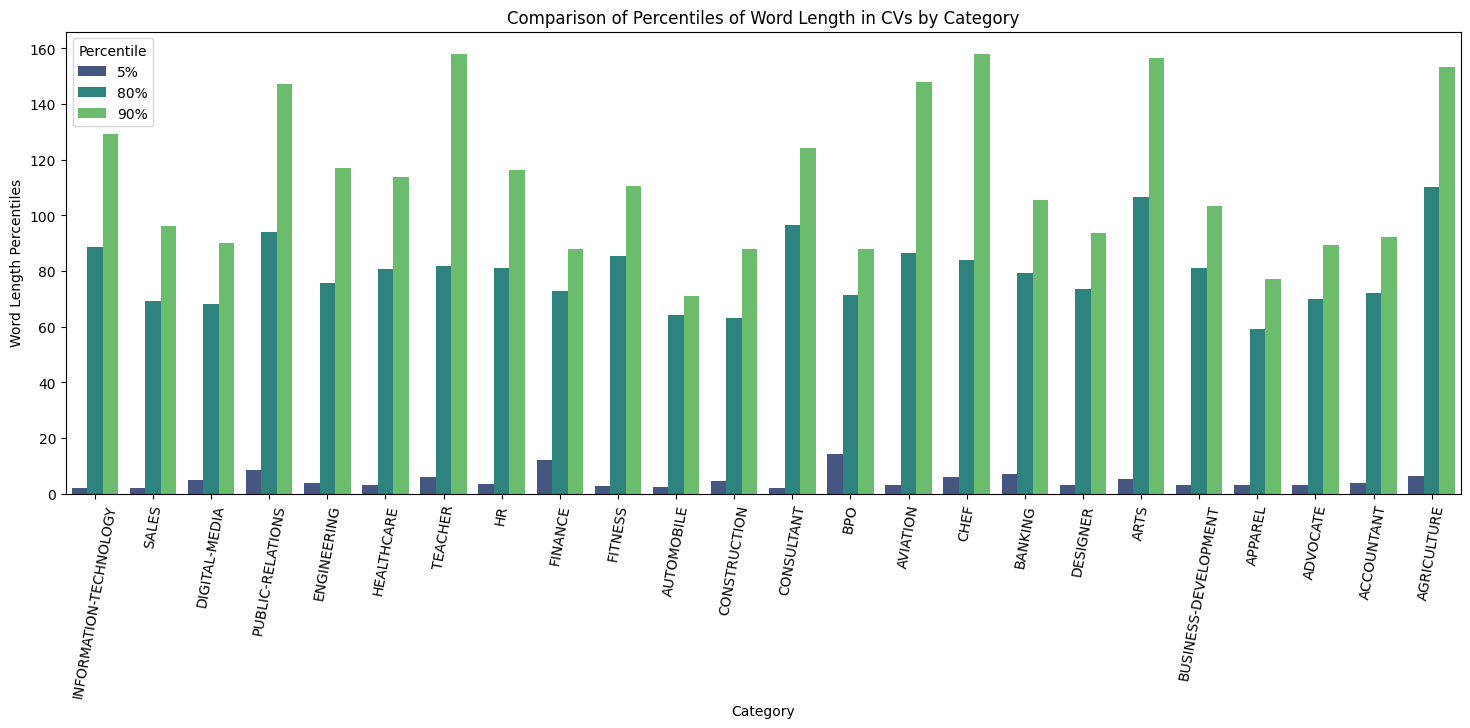

In [33]:
# Reshape the DataFrame to long format for easier plotting
stats_df_long = pd.melt(stats_df, id_vars=['Category'], value_vars=['5%', '80%', '90%'])

# Create a bar plot to compare percentiles of word length for each category
plt.figure(figsize=(18, 6))
sns.barplot(data=stats_df_long, x='Category', y='value', hue='variable', palette='viridis')

plt.title('Comparison of Percentiles of Word Length in CVs by Category')
plt.xticks(rotation=80)
plt.xlabel('Category')
plt.ylabel('Word Length Percentiles')
plt.legend(title='Percentile')
plt.show();

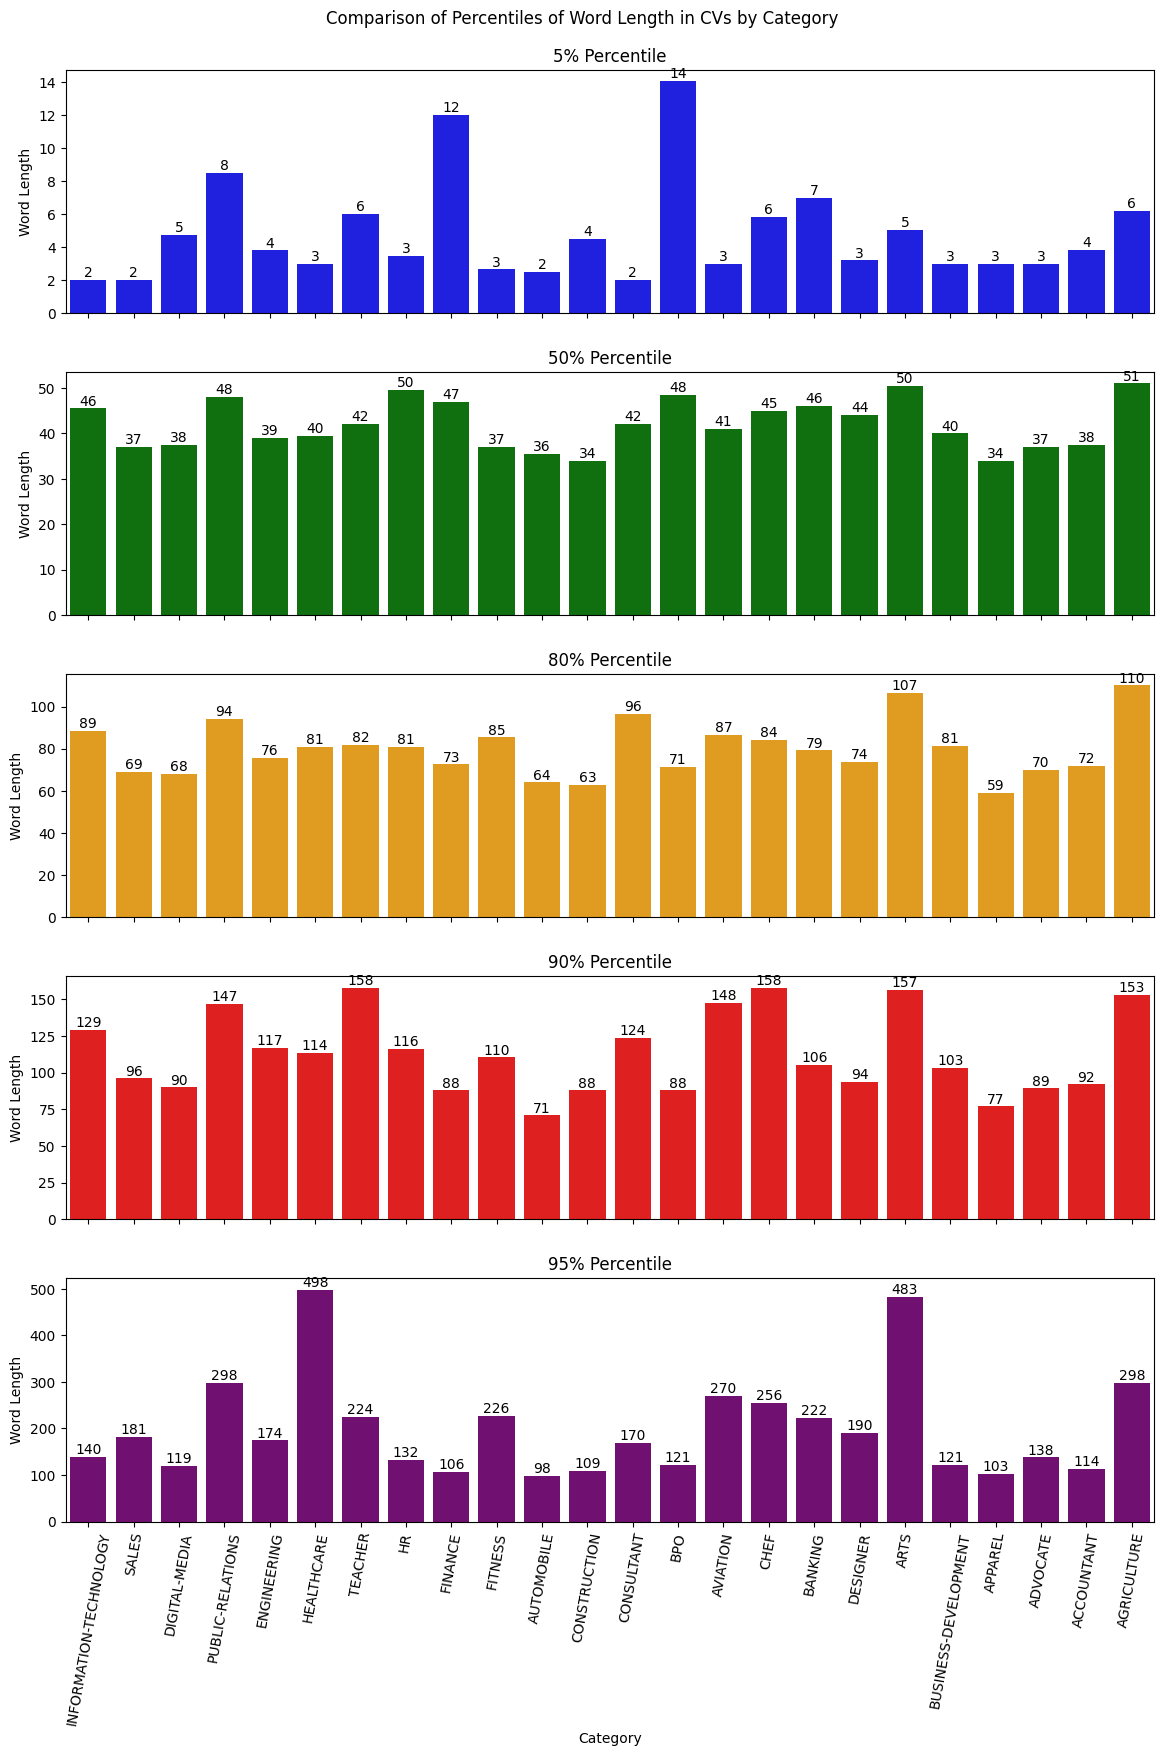

In [34]:
# Create a 5x1 subplot
fig, axes = plt.subplots(5, 1, figsize=(12, 18), sharex=True)

percentiles = ['5%', '50%', '80%', '90%', '95%']
colors = ['blue', 'green', 'orange', 'red', 'purple']

for i, percentile in enumerate(percentiles):
    # Create a bar plot for each percentile
    sns.barplot(data=stats_df, x='Category', y=percentile, color=colors[i], ax=axes[i])

    # Annotate the bars with actual values
    for index, row in stats_df.iterrows():
        value = row[percentile]
        axes[i].text(index, value, f'{round(value)}', ha='center', va='bottom', fontsize=10)

    axes[i].set_title(f'{percentile} Percentile')
    axes[i].set_ylabel('Word Length')

# Set the common x-axis label and rotate x-axis ticks
plt.xlabel('Category')
plt.xticks(rotation=80)
plt.suptitle('Comparison of Percentiles of Word Length in CVs by Category')

# Adjust spacing between subplots
plt.tight_layout(pad=2.0)

# Show the plots
plt.show();

In [35]:
!pip install datasets

In [36]:
jd_df = pd.DataFrame(jd_data)
jd_df.head()

NameError: name 'jd_data' is not defined

In [ ]:
!pip install contractions
import contractions
import string
from tqdm.notebook import tqdm
tqdm.pandas()  # This line enables the progress bar on apply


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 9.3 MB/s eta 0:00:00


In [47]:
import pandas as pd

url = "https://huggingface.co/datasets/jacob-hugging-face/job-descriptions/resolve/main/training_data.csv"
jd_df = pd.read_csv(url)

print(jd_df.head())


  company_name                                    job_description  \
0       Google  minimum qualifications\nbachelors degree or eq...   
1        Apple  description\nas an asc you will be highly infl...   
2      Netflix  its an amazing time to be joining netflix as w...   
3  Robert Half  description\n\nweb designers looking to expand...   
4    TrackFive  at trackfive weve got big goals were on a miss...   

                              position_title  description_length  \
0                           Sales Specialist                2727   
1                 Apple Solutions Consultant                 828   
2  Licensing Coordinator - Consumer Products                3205   
3                               Web Designer                2489   
4                              Web Developer                3167   

                                      model_response  
0   {\n  "Core Responsibilities": "Responsible fo...  
1   {\n  "Core Responsibilities": "as an asc you ...  
2   {\n  "C

In [43]:
jd_df['job_description'] = jd_df['job_description'].progress_apply(text_cleaning)

Progress Bar: 100%|██████████| 853/853 [00:00<00:00, 1312.53it/s]


In [44]:
# A lot of position_title are present
jd_df.position_title.unique()

len(jd_df.position_title.unique())

725

In [45]:
# A lot of companies
jd_df.company_name.unique()

len(jd_df.company_name.unique())

853

In [40]:
url = "https://huggingface.co/datasets/jacob-hugging-face/job-descriptions/resolve/main/training_data.csv"
jd_df

,company_name,job_description,position_title,description_length,model_response
0,Google,minimum qualifications\nbachelors degree or eq...,Sales Specialist,2727,"{\n ""Core Responsibilities"": ""Responsible fo..."
1,Apple,description\nas an asc you will be highly infl...,Apple Solutions Consultant,828,"{\n ""Core Responsibilities"": ""as an asc you ..."
2,Netflix,its an amazing time to be joining netflix as w...,Licensing Coordinator - Consumer Products,3205,"{\n ""Core Responsibilities"": ""Help drive bus..."
3,Robert Half,description\n\nweb designers looking to expand...,Web Designer,2489,"{\n ""Core Responsibilities"": ""Designing webs..."
4,TrackFive,at trackfive weve got big goals were on a miss...,Web Developer,3167,"{\n ""Core Responsibilities"": ""Build and layo..."
...,...,...,...,...,...
848,Menards,job description\n\nparttime\n\nmake big money ...,Management Internship,1122,"{\n ""Core Responsibilities"": ""Responsibiliti..."
849,Parker,responsibilities\nparkers internship program w...,Human Resources Internship - Corporate (Year-...,3840,"{\n ""Core Responsibilities"": ""Assist in gene..."
850,Borgen Project,the borgen project is an innovative national ...,Writer / Journalist Internship,897,"{\n ""Core Responsibilities"": ""Write one arti..."
851,Wyndham Destinations,put the world on vacation\n\nat wyndham destin...,Inbound Customer Service / Sales (Remote),4604,"{\n ""Core Responsibilities"": ""Answer inbound..."


In [42]:
jd_df = pd.DataFrame(jd_df)
jd_df.head()

,company_name,job_description,position_title,description_length,model_response
0,Google,minimum qualifications\nbachelors degree or eq...,Sales Specialist,2727,"{\n ""Core Responsibilities"": ""Responsible fo..."
1,Apple,description\nas an asc you will be highly infl...,Apple Solutions Consultant,828,"{\n ""Core Responsibilities"": ""as an asc you ..."
2,Netflix,its an amazing time to be joining netflix as w...,Licensing Coordinator - Consumer Products,3205,"{\n ""Core Responsibilities"": ""Help drive bus..."
3,Robert Half,description\n\nweb designers looking to expand...,Web Designer,2489,"{\n ""Core Responsibilities"": ""Designing webs..."
4,TrackFive,at trackfive weve got big goals were on a miss...,Web Developer,3167,"{\n ""Core Responsibilities"": ""Build and layo..."


In [48]:
# Sample JD

# jd_df['model_response'][0]
print(jd_df['job_description'][0])

minimum qualifications
bachelors degree or equivalent practical experience years of experience in saas or productivity tools businessexperience managing enterprise accounts with sales cycles
preferred qualifications
 years of experience building strategic business partnerships with enterprise customersability to work through and with a reseller ecosystem to scale the businessability to plan pitch and execute a territory business strategyability to build relationships and to deliver results in a crossfunctionalmatrixed environmentability to identify crosspromoting and uppromoting opportunities within the existing account baseexcellent account management writtenverbal communication strategic and analyticalthinking skills
about the job
as a member of the google cloud team you inspire leading companies schools and government agencies to work smarter with google tools like google workspace search and chrome you advocate the innovative power of our products to make organizations more product

In [49]:
def text_cleaning(text:str) -> str:
    if pd.isnull(text):
        return

    # lower-case everything
    text = text.lower().strip()

    # For removing puctuations
    translator = str.maketrans('', '', string.punctuation)

    # expand all the short-form words
    text = contractions.fix(text)

    # remove any special chars
    text = re.sub(r'http\S+|www\S+|https\S+', '', text) # Remove URLs
    text = re.sub(r'\S+@\S+', '', text) # Remove emails
    text = re.sub(r'\b\d{1,3}[-./]?\d{1,3}[-./]?\d{1,4}\b', '', text) # Remove phone numbers
    text = text.translate(translator) # Remove puctuations
    text = re.sub(r'[^a-zA-Z]', ' ', text) # Remove other non-alphanumeric characters

    return text.strip()

In [50]:
# We have 15 Resumes where Skills & Education were not extracted
# So, let's remove them
cv_df = df[~(df['Skills'].isna() & df['Education'].isna())].reset_index(drop=True)

# Filling the null values in Skills & Education with Empty String before concatinating them
cv_df = cv_df.fillna(value='')

# Let's stitch together Skills & Education, similar to given in job description.
cv_df['CV'] = cv_df['Skills'] + ' ' + cv_df['Education']

# Doing text cleaning
cv_df['CV'] = cv_df['CV'].progress_apply(text_cleaning)

Progress Bar: 100%|██████████| 2469/2469 [00:00<00:00, 5851.45it/s]


In [51]:
cv_df.shape

(2469, 5)

In [52]:
# Sample job descriptions
job_descriptions = jd_df['job_description'].apply(text_cleaning)[:15].to_list() # jd_df['job_description'][:15]

# Sample resumes (replace with your extracted resume data)
resumes = cv_df['CV'].to_list()

In [53]:
job_descriptions

['minimum qualifications bachelors degree or equivalent practical experience years of experience in saas or productivity tools businessexperience managing enterprise accounts with sales cycles preferred qualifications  years of experience building strategic business partnerships with enterprise customersability to work through and with a reseller ecosystem to scale the businessability to plan pitch and execute a territory business strategyability to build relationships and to deliver results in a crossfunctionalmatrixed environmentability to identify crosspromoting and uppromoting opportunities within the existing account baseexcellent account management writtenverbal communication strategic and analyticalthinking skills about the job as a member of the google cloud team you inspire leading companies schools and government agencies to work smarter with google tools like google workspace search and chrome you advocate the innovative power of our products to make organizations more produ

In [54]:
cv_df

,Skills,Education,ID,Category,CV
0,"Procurement Clerk, Purchasing Agent, Computer ...","Bachelor of Arts , Business Admin and Manageme...",51363762,INFORMATION-TECHNOLOGY,procurement clerk purchasing agent computer pr...
1,COMMUNICATION,,21283365,INFORMATION-TECHNOLOGY,communication
2,"Executive and Legal Support, Business Analysis...","2014 College of Lake County - City , State CFT...",91697974,INFORMATION-TECHNOLOGY,executive and legal support business analysis ...
3,Project management Results-oriented,Family Financial Planning (Graduate Certificat...,16899268,INFORMATION-TECHNOLOGY,project management resultsoriented family fina...
4,"Administrative, Analyst, Army, Agency, cable, ...",Bachelor of Science (BS) : Information Technol...,12045067,INFORMATION-TECHNOLOGY,administrative analyst army agency cable cabli...
...,...,...,...,...,...
2464,"Adobe Creative Suite, Acrobat, After Effects, ...",,89740812,AGRICULTURE,adobe creative suite acrobat after effects dre...
2465,,Bachelor of Arts : Criminal Justice California...,27689009,AGRICULTURE,bachelor of arts criminal justice california ...
2466,Cash handling,"2015\nBrown-Mackie College\nCity , State , USA...",36102323,AGRICULTURE,cash handling brownmackie college city state...
2467,Operations management Top sales performer,,69859102,AGRICULTURE,operations management top sales performer


In [55]:
!pip install transformers

In [56]:
import torch
from datasets import load_dataset
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics.pairwise import cosine_similarity

In [57]:
%%time
from transformers import DistilBertTokenizer, DistilBertModel
import torch


# Initialize the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')


# Tokenize and embed job descriptions
job_description_embeddings = []
for description in job_descriptions:
    tokens = tokenizer(description, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        output = model(**tokens)
    embeddings = output.last_hidden_state.mean(dim=1).numpy()
    job_description_embeddings.append(embeddings[0])  # Flatten the embeddings to 1D

# Tokenize and embed resumes
resume_embeddings = []
for resume in resumes:
    tokens = tokenizer(resume, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        output = model(**tokens)
    embeddings = output.last_hidden_state.mean(dim=1).numpy()
    resume_embeddings.append(embeddings[0])  # Flatten the embeddings to 1D

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

CPU times: user 7min, sys: 4.1 s, total: 7min 4s
Wall time: 7min 11s


In [58]:
job_description_embeddings[0].shape, resume_embeddings[0].shape

((768,), (768,))

In [59]:
len(job_description_embeddings), len(resume_embeddings)

(15, 2469)

In [60]:
# Calculate cosine similarity between job descriptions and resumes
similarity_scores = cosine_similarity(job_description_embeddings, resume_embeddings)
similarity_scores

array([[0.86753654, 0.17545891, 0.84757143, ..., 0.622665  , 0.62291414,
        0.8866242 ],
       [0.8218133 , 0.20970808, 0.7962853 , ..., 0.6494328 , 0.6484985 ,
        0.8038984 ],
       [0.8729645 , 0.14183518, 0.8542696 , ..., 0.63520175, 0.5942157 ,
        0.9151184 ],
       ...,
       [0.8694275 , 0.16850443, 0.8533261 , ..., 0.6321837 , 0.5908753 ,
        0.8998238 ],
       [0.87396824, 0.26108062, 0.85106725, ..., 0.6679591 , 0.64902544,
        0.811311  ],
       [0.88366294, 0.18478994, 0.86614215, ..., 0.6429582 , 0.6045886 ,
        0.9069771 ]], dtype=float32)

In [61]:
# Rank candidates for each job description based on similarity scores
num_top_candidates = 5
top_candidates = []

for i, job_description in enumerate(job_descriptions):
    candidates_with_scores = list(enumerate(similarity_scores[i]))
    candidates_with_scores.sort(key=lambda x: x[1], reverse=True)
    top_candidates_for_job = candidates_with_scores[:num_top_candidates]
    top_candidates.append(top_candidates_for_job)

# Print the top candidates for each job description
for i, job_description in enumerate(job_descriptions):
    print(f"Top candidates for JD {i+1} - Postition: {jd_df['position_title'][i]}")
    for candidate_index, score in top_candidates[i]:
        print(f"  Candidate {candidate_index + 1} - Similarity Score: {score:.4f} - {cv_df['Category'][candidate_index]}/{cv_df['ID'][candidate_index]}.pdf")
        # print(f"  Resume: {resumes[candidate_index]}")
    print()

Top candidates for JD 1 - Postition: Sales Specialist
  Candidate 784 - Similarity Score: 0.9415 - HR/18827609.pdf
  Candidate 2459 - Similarity Score: 0.9388 - AGRICULTURE/62994611.pdf
  Candidate 1858 - Similarity Score: 0.9387 - ARTS/43622023.pdf
  Candidate 2379 - Similarity Score: 0.9377 - ACCOUNTANT/16237710.pdf
  Candidate 651 - Similarity Score: 0.9314 - HEALTHCARE/10466208.pdf

Top candidates for JD 2 - Postition: Apple Solutions Consultant
  Candidate 2260 - Similarity Score: 0.9236 - ADVOCATE/22391901.pdf
  Candidate 1993 - Similarity Score: 0.9165 - BUSINESS-DEVELOPMENT/95382114.pdf
  Candidate 1031 - Similarity Score: 0.9159 - FITNESS/21238396.pdf
  Candidate 1570 - Similarity Score: 0.9155 - CHEF/21869994.pdf
  Candidate 1924 - Similarity Score: 0.9146 - ARTS/54100393.pdf

Top candidates for JD 3 - Postition: Licensing Coordinator - Consumer Products
  Candidate 1858 - Similarity Score: 0.9598 - ARTS/43622023.pdf
  Candidate 352 - Similarity Score: 0.9496 - PUBLIC-RELATIO

In [62]:
from transformers import DistilBertTokenizer, DistilBertModel

# Assuming 'model' is your trained DistilBERT model
model.save_pretrained('./DistilBertModel')
tokenizer.save_pretrained('./DistilBertTokenizer')

('./DistilBertTokenizer/tokenizer_config.json',
 './DistilBertTokenizer/special_tokens_map.json',
 './DistilBertTokenizer/vocab.txt',
 './DistilBertTokenizer/added_tokens.json')